In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import time, datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [2]:
train = pd.read_csv('BPI_Challenge_2012-training.csv')
test = pd.read_csv('BPI_Challenge_2012-test.csv')

### **Functions concerning time**

In [3]:
def month(x):
    """Convert object to the month of year

    Args:
        x (str)

    Returns:
        DateTime object
    """
    return x.month

def day(x):
    """Convert object to the day of year

    Args:
        x (str)

    Returns:
        DateTime object
    """
    return x.day

def week(x):
    """Convert object to the week of year

    Args:
        x (str)

    Returns:
        DateTime object
    """
    return x.week

def day_week(x):
    """Convert object to the day of week

    Args:
        x (str)

    Returns:
        DateTime object
    """
    return x.weekday()

def time_of_day(x):
    """Convert object to the hour of the day

    Args:
        x (str)

    Returns:
        DateTime object
    """
    return x.hour

### **Function 'time_conversion**

In [4]:
def time_conversion(dataframe):
    """Transform 'event time:timestamp' and 'case REG_DATE' from str to DateTime in a given Dataframe
        Additionally, this function creates timestamps for the start and finish of a task in a seperate column. 
        The difference between these timestaps is the time to complete a task, which is also added to the dataframe.

        Commented out lines are still for discussion
        
    Args:
        dataframe (pd.DataFrame): A pd.DataFrame in the format from the BPI_challenge 2012

    Returns:
        dataframe_output: A pd.DataFrame with all the strings reformatted to DateTime in the 'event time:timestamp' and 'case REG_DATE' columns
    """
    
#     dataframe.drop(columns = ['eventID '], inplace=True) # Drop eventID
    dataframe.reset_index(inplace=True)
    
    #Transform 'event time:timestamp' and 'case REG_DATE' from str to DateTime  
    dataframe['case REG_DATE'] =  pd.to_datetime(dataframe['case REG_DATE'], format='%d-%m-%Y %H:%M:%S.%f')
    dataframe['event time:timestamp'] =  pd.to_datetime(dataframe['event time:timestamp'], format='%d-%m-%Y %H:%M:%S.%f')
    
    #Creates timestamps for the start and finish of a task in a seperate column + the time to complete the task.
    dataframe['timestamp_start'] = dataframe['case REG_DATE'].values.astype(np.int64) // 10 ** 9
    dataframe['timestamp_finish'] = dataframe['event time:timestamp'].values.astype(np.int64) // 10 ** 9 
#     dataframe['time_to_complete']= (dataframe["event time:timestamp"] - dataframe["case REG_DATE"])/10**6


    # Convert the timestamps of the event time to day of week, specific day and time of that day.
    
    dataframe["day_week"] = dataframe["event time:timestamp"].apply(day_week)
    # dataframe["week"] = dataframe["event time:timestamp"].apply(week)
#     dataframe["day_month"] = dataframe["event time:timestamp"].apply(day)
    # dataframe["month"] = dataframe["event time:timestamp"].apply(month)
    dataframe['time_of_day'] = dataframe['event time:timestamp'].apply(time_of_day)
    
    return dataframe

### ** Function 'encoding'**

In [5]:
def calculate_time_difference(dataframe):
    return dataframe.apply(lambda row: (row['next_time'] - row['event time:timestamp']).total_seconds(), axis=1)

def calculate_time_prev(dataframe):
    return dataframe.apply(lambda row: (row['event time:timestamp'] - row['prev_time']).total_seconds(), axis=1)

In [6]:
def encoding(dataframe):
    """Encoding 

    What kind of encoding is this exactly?
    
    Args:
        dataframe (pd.DataFrame): A pd.DataFrame in the format from the BPI_challenge 2012

    Returns:
        dataframe: A pd.DataFrame with cases and events sorted wrt time, each event has a position within its case
    """
    # sort cases wrt time, for each case sort events 
    dataframe.sort_values(['timestamp_start',"timestamp_finish"], axis=0, ascending=True, inplace=True, ignore_index=True)
    
    # assign the position in the sequence to each event
    dataframe['position'] = None
    dataframe['position'] = dataframe.groupby('case concept:name').cumcount() + 1
    
    
    # create columns with previous and future (times of) events

   
    dataframe["prev_event"] = dataframe.groupby("case concept:name")["event concept:name"].shift(1)
    dataframe["2prev_event"] = dataframe.groupby("case concept:name")["event concept:name"].shift(2)
    dataframe["next_event"] = dataframe.groupby("case concept:name")["event concept:name"].shift(-1)

    dataframe["prev_time"] = dataframe.groupby("case concept:name")["event time:timestamp"].shift(1)
    dataframe["next_time"] = dataframe.groupby("case concept:name")["event time:timestamp"].shift(-1)
    
    
    dataframe["next_event"].fillna("LAST EVENT", inplace=True)
    dataframe["prev_event"].fillna("FIRST EVENT", inplace=True)
    dataframe["2prev_event"].fillna("FIRST EVENT", inplace=True)
    
    #     these values should be empty and filling them equals creating wrong data, but otherwise models dont work :( 
    dataframe["next_time"].fillna(method='ffill', inplace=True)
    dataframe["prev_time"].fillna(method='bfill', inplace=True)    
    
    dataframe['seconds_next'] = calculate_time_difference(dataframe)
    dataframe['seconds_prev'] = calculate_time_prev(dataframe)
    
    
        # how many events are left until the end of the case
    dataframe['position inverse'] = dataframe.groupby('case concept:name').cumcount(ascending=False)+1

    # how many cases start after the current event, inclusive
    dataframe['case start count'] = dataframe[dataframe['position'] == 1].groupby('position').cumcount(ascending=False) + 1

    # how many cases end before the current event, inclusive
    dataframe['case end count'] = dataframe[dataframe['position inverse'] == 1].groupby('position inverse').cumcount() + 1

    dataframe.at[-1, 'case start count'] = 0
    dataframe.at[0, 'case end count'] = 0
    dataframe['case start count'].fillna(method='bfill', inplace = True)
    dataframe['case end count'].fillna(method='ffill', inplace = True)
    
    
    total_cases = dataframe['case start count'].loc[0]
    dataframe['active cases'] = total_cases - dataframe['case start count'].shift(periods = -1, fill_value=0) - dataframe['case end count']
    dataframe.drop(dataframe.tail(1).index,inplace=True)
    
    return dataframe

### **Function: 'preprocessing'**

In [7]:
def preprocessing(dataframe):
    """Does all the processing needed for the naive estimator

    Args:
        dataframe (pd.DataFrame): A pd.DataFrame in the format from the BPI_challenge 2012
    """
    pp_df = encoding(time_conversion(dataframe))
    
    
    return pp_df

## **Preprocessing and splitting**

In [8]:
# merge the data sets and preprocess
train = pd.concat([train, test], axis="rows", ignore_index=True)


train = preprocessing(train)
# test = preprocessing(test)

In [9]:
# train.drop(['index'],axis='columns',inplace=True)

In [10]:
# a check for duplicate events, gives error if none repeat
# pd.concat(g for _, g in train.groupby("eventID ") if len(g) > 1).tail(50)

In [11]:
test = train.loc[220981:]
train = train.loc[:220981]


In [12]:
lst=['W_Wijzigen contractgegevens', 'W_Wijzigen contractgegevens', 'A_CANCELLED', 'W_Wijzigen contractgegevens']

train['event concept:name'].any() in lst

False

In [13]:
# Find the timestamp of the first event in the test set
first_test_event_timestamp = test['event time:timestamp'].min()

# Filter out cases that end after the first test event starts or start before the first train event
train_data_filtered = train.groupby('case concept:name').filter(lambda g: g['event time:timestamp'].min() < first_test_event_timestamp and g['event time:timestamp'].max() > first_test_event_timestamp)



In [14]:
train.shape, test.shape

((220982, 25), (41219, 25))

In [15]:
train_data_filtered.shape, test.shape

((183358, 25), (41219, 25))

In [16]:
first_test_event_timestamp

Timestamp('2012-02-07 20:30:15.364000')

### **Export dataframe to .CSV**

In [17]:
train_data_filtered.to_csv('preprocessed_train.csv')
test.to_csv('preprocessed_test.csv')

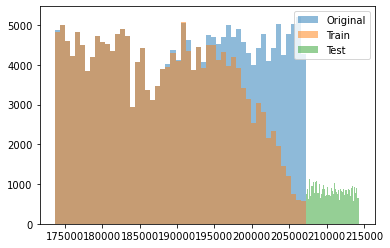

In [18]:

# Plot histogram of the feature in the original dataset
plt.hist(train['case concept:name'], bins=50, alpha=0.5, label='Original')

# Plot histogram of the feature in the training set
plt.hist(train_data_filtered['case concept:name'], bins=50, alpha=0.5, label='Train')

# Plot histogram of the feature in the testing set
plt.hist(test['case concept:name'], bins=50, alpha=0.5, label='Test')

plt.legend(loc='upper right')
plt.show()


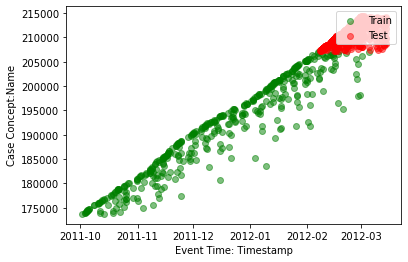

In [19]:
# Plot scatter plot of event timestamp vs case concept:name for the training data
plt.scatter(train['event time:timestamp'].sample(frac=0.002, replace=True, random_state=1), train['case concept:name'].sample(frac=0.002, replace=True, random_state=1), alpha=0.5, label='Train', color='green')

# Plot scatter plot of event timestamp vs case concept:name for the testing data
plt.scatter(test['event time:timestamp'].sample(frac=0.02, replace=True, random_state=1), test['case concept:name'].sample(frac=0.02, replace=True, random_state=1), alpha=0.5, label='Test', color='red')

plt.xlabel('Event Time: Timestamp')
plt.ylabel('Case Concept:Name')
plt.legend(loc='upper right')
plt.show()

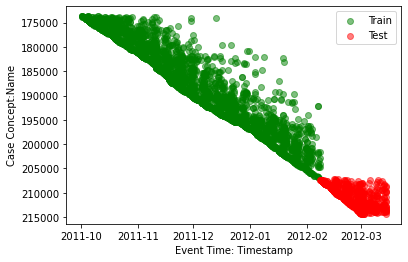

In [20]:
# Plot scatter plot of event timestamp vs case concept:name for the training data

plt.scatter(train_data_filtered['event time:timestamp'].sample(frac=0.02, replace=True, random_state=1), train_data_filtered['case concept:name'].sample(frac=0.02, replace=True, random_state=1), alpha=0.5, label='Train', color='green')

# Plot scatter plot of event timestamp vs case concept:name for the testing data
plt.scatter(test['event time:timestamp'].sample(frac=0.02, replace=True, random_state=1), test['case concept:name'].sample(frac=0.02, replace=True, random_state=1), alpha=0.5, label='Test', color='red')

plt.rcParams["figure.figsize"] = (20,20)
plt.xlabel('Event Time: Timestamp')
plt.ylabel('Case Concept:Name')
plt.legend(loc='upper right')
plt.gca().invert_yaxis()
plt.show()

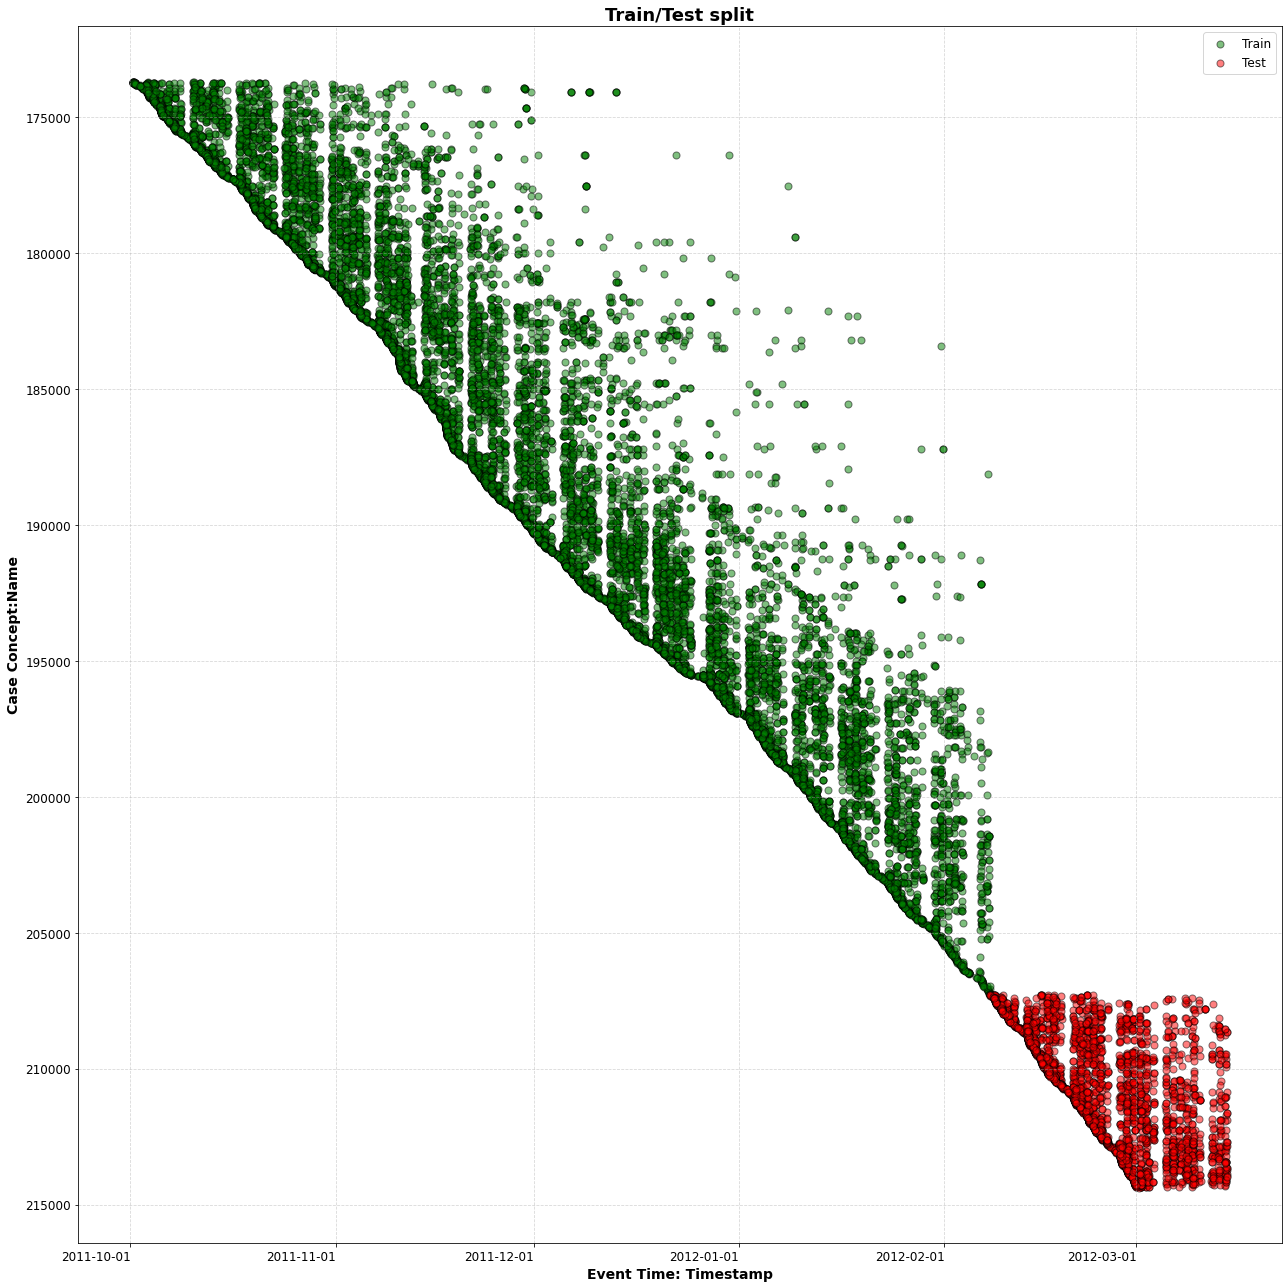

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Prepare the data
train_x = train_data_filtered['event time:timestamp'].sample(frac=0.1, replace=True, random_state=1)
train_y = train_data_filtered['case concept:name'].sample(frac=0.1, replace=True, random_state=1)

test_x = test['event time:timestamp'].sample(frac=0.1, replace=True, random_state=1)
test_y = test['case concept:name'].sample(frac=0.1, replace=True, random_state=1)

# Create the scatter plot
fig, ax = plt.subplots(figsize=(18, 18))

ax.scatter(train_x, train_y, alpha=0.5, label='Train', color='green', s=50, edgecolors='black', linewidths=1)
ax.scatter(test_x, test_y, alpha=0.5, label='Test', color='red', s=50, edgecolors='black', linewidths=1)

# Configure the x-axis
ax.set_xlabel('Event Time: Timestamp', fontsize=14, fontweight='bold')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=0, ha='right', fontsize=12)

# Configure the y-axis
ax.set_ylabel('Case Concept:Name', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.yticks(fontsize=12)

# Add a legend
ax.legend(loc='upper right', fontsize=12)

# Add a title
plt.title('Train/Test split', fontsize=18, fontweight='bold')

# Show grid
ax.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()


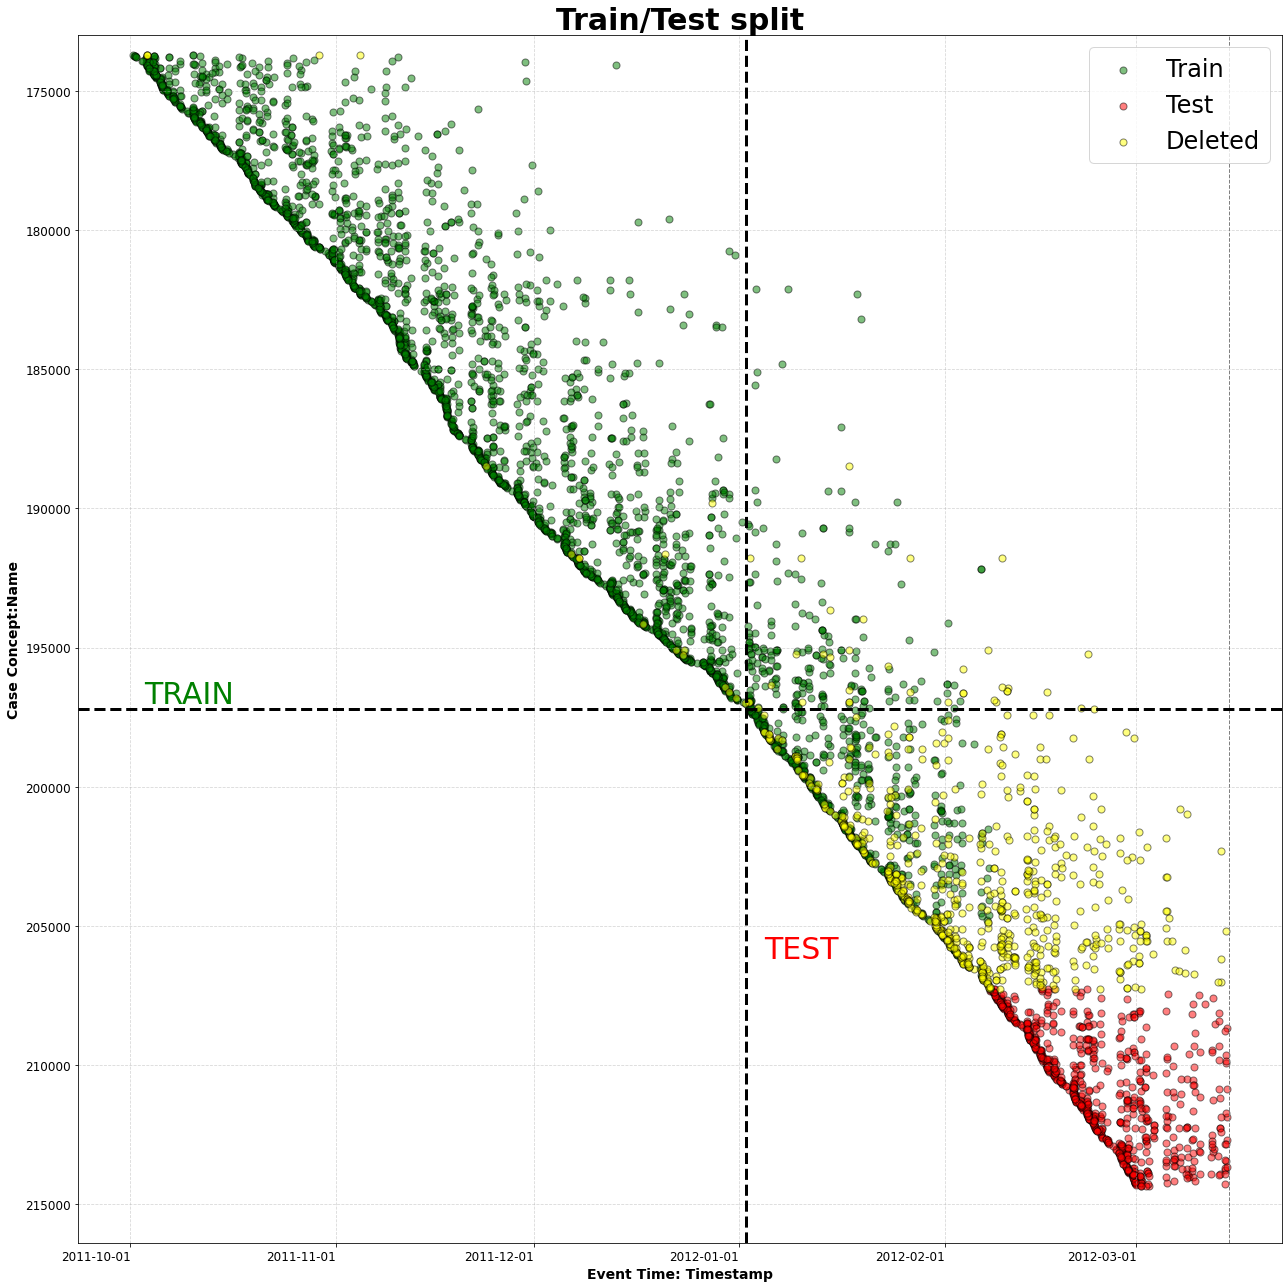

In [22]:
# calculate deleted data
deleted_data = train[~train['case concept:name'].isin(train_data_filtered['case concept:name'])]

train_x = train_data_filtered['event time:timestamp'].sample(frac=0.02, replace=True, random_state=1)
train_y = train_data_filtered['case concept:name'].sample(frac=0.02, replace=True, random_state=1)

test_x = test['event time:timestamp'].sample(frac=0.02, replace=True, random_state=1)
test_y = test['case concept:name'].sample(frac=0.02, replace=True, random_state=1)

deleted_x = deleted_data['event time:timestamp'].sample(frac=0.02, replace=True, random_state=1)
deleted_y = deleted_data['case concept:name'].sample(frac=0.02, replace=True, random_state=1)

fig, ax = plt.subplots(figsize=(18, 18))

ax.scatter(train_x, train_y, alpha=0.5, label='Train', color='green', s=50, edgecolors='black', linewidths=1)
ax.scatter(test_x, test_y, alpha=0.5, label='Test', color='red', s=50, edgecolors='black', linewidths=1)
ax.scatter(deleted_x, deleted_y, alpha=0.5, label='Deleted', color='yellow', s=50, edgecolors='black', linewidths=1)

# x axis
ax.set_xlabel('Event Time: Timestamp', fontsize=14, fontweight='bold')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=0, ha='right', fontsize=12)

# y axis
ax.set_ylabel('Case Concept:Name', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.yticks(fontsize=12)
ax.set_ylim(173000, ax.get_ylim()[0])
ax.invert_yaxis()

# legend
ax.legend(loc='upper right', fontsize=24)

# title
plt.title('Train/Test split', fontsize=30, fontweight='bold')

y_line = 1000 
x_line = mdates.date2num(pd.Timestamp('2012-03-15'))  

plt.axhline(y=y_line, color='gray', linestyle='--', linewidth=1)
plt.axvline(x=x_line, color='gray', linestyle='--', linewidth=1)

# x axis separation line
vline_date = pd.Timestamp('2012-01-02')
vline_x = mdates.date2num(vline_date)
plt.axvline(x=vline_x, color='black', linestyle='--', linewidth=3)

# y axis separation line
hline_case = 197219
plt.axhline(y=hline_case, color='black', linestyle='--', linewidth=3)

# Add the label for the horizontal line
label_yx = hline_case
label_xx = ax.get_xlim()[0] + 10  
plt.text(label_xx, label_yx, 'TRAIN', fontsize=30, color='green', rotation=0, ha='left', va='bottom')

# label for line
label_xy = ax.get_xlim()[0] + 115  
label_yy = ax.get_ylim()[0] - 10000
plt.text(label_xy, label_yy, 'TEST', fontsize=30, color='red', rotation=0, ha='right', va='bottom')

# grid
ax.grid(True, linestyle='--', alpha=0.5)

# plot
plt.tight_layout()
plt.show()
